In [1]:
data_dir = 'L:/DATA/ISIS/keras_ocr/'

import os
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf

import keras_ocr

## Train the recognizer
After some research, training the detector seems hard and time consuming, so we'll start by training the recognizer with our own pictures. To train the recognizer, we need small images of digits from ionograms. I cropped 60 ionograms and their metadata. Each of them looks like this.

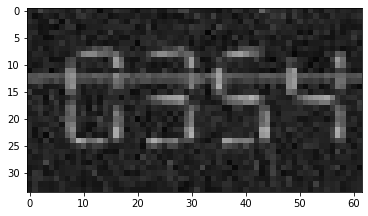

In [2]:
im = plt.imread(data_dir+'test_images/cropped/1-5.jpg')
plt.imshow(im)

I also created a txt file with the name of the images and the right numbers. I looks like this.

In [3]:
import pandas as pd

dataset = pd.read_csv(data_dir+'test_images/cropped/annotations.txt', header=None, 
                      names=['file','text'], dtype={'file' : str, 'text' : str})
dataset['file'] = data_dir+'test_images/cropped/' + dataset['file']
dataset['text'] = dataset['text'].astype(str)
dataset.insert(1, 'empty', None)

dataset.head(6)

,file,empty,text
0,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-1...,None,36
1,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-2...,None,00
2,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-3...,None,69
3,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-4...,None,11
4,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-5...,None,0354
5,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-5...,None,35


In [4]:
train_subset, test_subset = sklearn.model_selection.train_test_split(dataset, test_size=0.2)

train_subset.reset_index(inplace=True, drop=True)
test_subset.reset_index(inplace=True, drop=True)

train = []
for i in range(len(train_subset)):
    train.append(tuple(train_subset.loc[i].to_list()))

test = []
for i in range(len(test_subset)):
    test.append(tuple(test_subset.loc[i].to_list()))

In [2]:
'''train_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='train',
    cache_dir=data_dir
)
test_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='test',
    cache_dir=data_dir
)
train_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]
test_labels = [(filepath, box, word.lower()) for filepath, box, word in test_labels]'''

Looking for L:/DATA/ISIS/keras_ocr\borndigital\Challenge1_Training_Task3_Images_GT.zip
Looking for L:/DATA/ISIS/keras_ocr\borndigital\Challenge1_Test_Task3_Images.zip
Looking for L:/DATA/ISIS/keras_ocr\borndigital\test\Challenge1_Test_Task3_GT.txt


In [5]:
import string
recognizer = keras_ocr.recognition.Recognizer(alphabet=string.digits)
recognizer.compile()

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\mfortier\.keras-ocr\crnn_kurapan_notop.h5


In [6]:
batch_size = 8
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

#train_labels, validation_labels = sklearn.model_selection.train_test_split(train, test_size=0.2, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train, augmenter), (test, None)]
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

144 / 144 instances have illegal characters.
text: 36


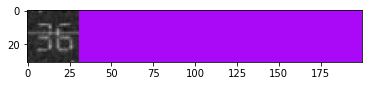

In [7]:
image, text = next(training_image_gen)
print('text:', text)
plt.imshow(image)

In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_borndigital.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
]
recognizer.training_model.fit(
    training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=1000,
    workers=0,
    batch_size=batch_size
)

Epoch 1/1000
18/18 [==============================] - 24s 683ms/step - loss: 18.6209 - val_loss: 7.5512
Epoch 2/1000
18/18 [==============================] - 5s 246ms/step - loss: 7.0948 - val_loss: 8.6194
Epoch 3/1000
18/18 [==============================] - 4s 230ms/step - loss: 6.1276 - val_loss: 5.8970
Epoch 4/1000
18/18 [==============================] - 4s 238ms/step - loss: 4.5017 - val_loss: 3.2215
Epoch 5/1000
18/18 [==============================] - 4s 242ms/step - loss: 2.5588 - val_loss: 1.8668
Epoch 6/1000
18/18 [==============================] - 5s 255ms/step - loss: 1.2712 - val_loss: 1.6109
Epoch 7/1000
18/18 [==============================] - 5s 296ms/step - loss: 0.4692 - val_loss: 0.6966
Epoch 8/1000
18/18 [==============================] - 5s 255ms/step - loss: 0.4474 - val_loss: 0.5402
Epoch 9/1000
18/18 [==============================] - 5s 264ms/step - loss: 0.3738 - val_loss: 2.0572
Epoch 10/1000
18/18 [==============================] - 4s 245ms/step - loss: 0.2

1/1 [==============================] - 2s 2s/step
Predicted: 364, Actual:  364


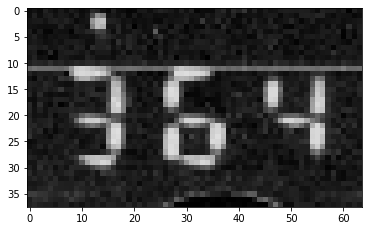

In [10]:
image_filepath, _, actual = test[1]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

Looking for C:\Users\mfortier\.keras-ocr\craft_mlt_25k.h5
1/1 [==============================] - 0s 88ms/step


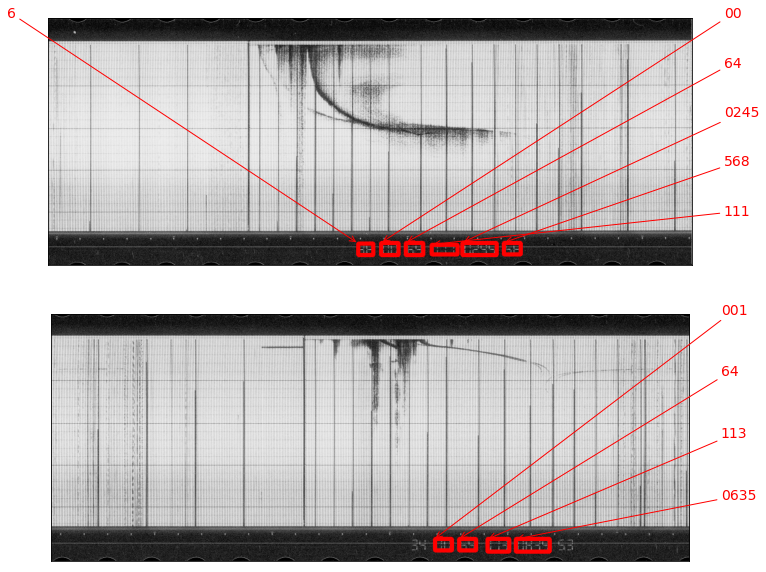

In [12]:
subdir_path = 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/'
pipeline = keras_ocr.pipeline.Pipeline(recognizer=recognizer)
images = [keras_ocr.tools.read(img) for img in [subdir_path + 'Image0005.png',subdir_path + 'Image0338.png']]
prediction_groups = pipeline.recognize(images)
# plot the text predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(15, 10))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, 
                                    predictions=predictions, 
                                    ax=ax)